# Importações e funções auxiliares

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random
from collections import defaultdict

# our classes
from agent import Agent, QLearningAgent, MonteCarloAgent
from environment import Environment
from screen import Screen

# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action

def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

# Monte Carlo

### Every Visit

n time: 6.1907875537872314 seconds
Max. Score: 41
Mean Last Scores: 15.8
Game 799      Score: 8
Run time: 6.195788383483887 seconds
Max. Score: 41
Mean Last Scores: 15.64
Game 800      Score: 19
Run time: 6.206790924072266 seconds
Max. Score: 41
Mean Last Scores: 15.74
Game 801      Score: 28
Run time: 6.222794532775879 seconds
Max. Score: 41
Mean Last Scores: 15.8
Game 802      Score: 19
Run time: 6.236797571182251 seconds
Max. Score: 41
Mean Last Scores: 15.96
Game 803      Score: 25
Run time: 6.248800277709961 seconds
Max. Score: 41
Mean Last Scores: 16.16
Game 804      Score: 24
Run time: 6.263803720474243 seconds
Max. Score: 41
Mean Last Scores: 16.5
Game 805      Score: 13
Run time: 6.270805358886719 seconds
Max. Score: 41
Mean Last Scores: 16.24
Game 806      Score: 25
Run time: 6.28480863571167 seconds
Max. Score: 41
Mean Last Scores: 16.36
Game 807      Score: 10
Run time: 6.290809869766235 seconds
Max. Score: 41
Mean Last Scores: 16.16
Game 808      Score: 5
Run time: 6.29381

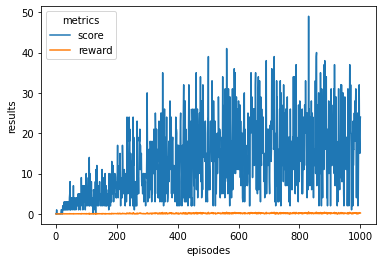

Run time: 8.328271389007568 seconds
Max. Score: 49
Mean Last Scores: 16.84


In [16]:
def run_monte_carlo(agent: Agent, reward_function, episodes, display, speed, verbose=True, first_visit=False):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}

    returns_sum = {} #defaultdict(float)
    returns_count = {} #defaultdict(float)

    start = time.time()
    while episode < episodes:
        states_and_actions_visited = []

        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()

            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            #decoded_action1 = decode_action(action1)
            #decoded_action2 = decode_action(action2)
            #agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)

            states_and_actions_visited.append((state2, action2, reward))

            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        # Acabou o episódio, hora de aprender
        #sa_in_episode = set([(tuple(x[0]), x[1]) for x in states_and_actions_visited])
        G = 0
        for i, step in enumerate(states_and_actions_visited[::-1]):
            state, action, r = step
            G = agent.gamma*G + r

            do_update = True

            if first_visit:
                if state in [x[0] for x in states_and_actions_visited[::-1][len(states_and_actions_visited)-i:]]:
                    do_update = False

            if do_update:
                sa_pair = (step[0], decode_action(step[1]))

                if sa_pair in returns_sum:
                    returns_sum[sa_pair] += G
                else:
                    returns_sum[sa_pair] = G

                if sa_pair in returns_count:
                    returns_count[sa_pair] += 1.0
                else:
                    returns_count[sa_pair] = 1

                average = returns_sum[sa_pair] / returns_count[sa_pair]
                agent.Q[sa_pair[0], sa_pair[1] ] = average
                #agent.Q[state, action] = agent.Q[state, action] + 1/returns_count[sa_pair]

        # Incrementar episódios e ir guardando as nossas métricas
        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')


        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)
        
        print('Run time:', (end-start), 'seconds')
        print('Max. Score:', max(metrics['scores']))
        print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break
    


    return metrics

N0 = 1
gamma = 1

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

: 8
Game 159      Score: 6
Game 160      Score: 9
Game 161      Score: 10
Game 162      Score: 8
Game 163      Score: 11
Game 164      Score: 6
Game 165      Score: 14
Game 166      Score: 8
Game 167      Score: 8
Game 168      Score: 6
Game 169      Score: 5
Game 170      Score: 7
Game 171      Score: 5
Game 172      Score: 5
Game 173      Score: 12
Game 174      Score: 4
Game 175      Score: 6
Game 176      Score: 6
Game 177      Score: 15
Game 178      Score: 10
Game 179      Score: 10
Game 180      Score: 25
Game 181      Score: 26
Game 182      Score: 15
Game 183      Score: 8
Game 184      Score: 9
Game 185      Score: 11
Game 186      Score: 28
Game 187      Score: 17
Game 188      Score: 4
Game 189      Score: 14
Game 190      Score: 2
Game 191      Score: 4
Game 192      Score: 14
Game 193      Score: 14
Game 194      Score: 13
Game 195      Score: 21
Game 196      Score: 4
Game 197      Score: 10
Game 198      Score: 11
Game 199      Score: 11
Game 200      Score: 17
Game 201

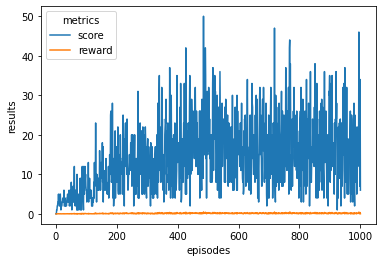

Run time: 10.517382144927979 seconds
Max. Score: 50
Mean Last Scores: 15.2


In [3]:
N0 = 1
gamma = 0.5

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

: 2
Game 132      Score: 4
Game 133      Score: 1
Game 134      Score: 3
Game 135      Score: 4
Game 136      Score: 3
Game 137      Score: 3
Game 138      Score: 3
Game 139      Score: 3
Game 140      Score: 4
Game 141      Score: 3
Game 142      Score: 2
Game 143      Score: 4
Game 144      Score: 1
Game 145      Score: 3
Game 146      Score: 4
Game 147      Score: 3
Game 148      Score: 4
Game 149      Score: 1
Game 150      Score: 2
Game 151      Score: 2
Game 152      Score: 3
Game 153      Score: 2
Game 154      Score: 3
Game 155      Score: 1
Game 156      Score: 3
Game 157      Score: 4
Game 158      Score: 6
Game 159      Score: 2
Game 160      Score: 3
Game 161      Score: 3
Game 162      Score: 3
Game 163      Score: 3
Game 164      Score: 1
Game 165      Score: 4
Game 166      Score: 4
Game 167      Score: 4
Game 168      Score: 3
Game 169      Score: 3
Game 170      Score: 3
Game 171      Score: 3
Game 172      Score: 3
Game 173      Score: 4
Game 174      Score: 4
Game 17

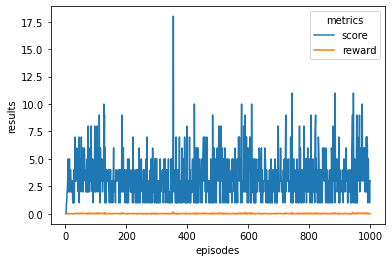

Run time: 4.469013452529907 seconds
Max. Score: 18
Mean Last Scores: 3.98


In [4]:
N0 = 1
gamma = 0.2
# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

### First Visit

   Score: 0
Game 132      Score: 0
Game 133      Score: 0
Game 134      Score: 0
Game 135      Score: 0
Game 136      Score: 0
Game 137      Score: 0
Game 138      Score: 0
Game 139      Score: 0
Game 140      Score: 0
Game 141      Score: 0
Game 142      Score: 0
Game 143      Score: 0
Game 144      Score: 0
Game 145      Score: 0
Game 146      Score: 0
Game 147      Score: 0
Game 148      Score: 0
Game 149      Score: 0
Game 150      Score: 0
Game 151      Score: 0
Game 152      Score: 0
Game 153      Score: 1
Game 154      Score: 0
Game 155      Score: 0
Game 156      Score: 0
Game 157      Score: 0
Game 158      Score: 0
Game 159      Score: 0
Game 160      Score: 0
Game 161      Score: 0
Game 162      Score: 0
Game 163      Score: 0
Game 164      Score: 0
Game 165      Score: 0
Game 166      Score: 0
Game 167      Score: 0
Game 168      Score: 0
Game 169      Score: 0
Game 170      Score: 0
Game 171      Score: 0
Game 172      Score: 0
Game 173      Score: 0
Game 174      Score: 0

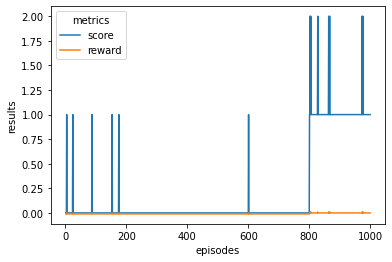

Run time: 2.3245270252227783 seconds
Max. Score: 2
Mean Last Scores: 1.04


In [5]:
N0 = 1
gamma = 1

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

In [12]:
N0 = 1
gamma = 0.5

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Run time: 0.003000497817993164 seconds
Max. Score: 0
Mean Last Scores: 0.0
Game 2      Score: 0
Run time: 0.006001472473144531 seconds
Max. Score: 0
Mean Last Scores: 0.0
Game 3      Score: 0
Run time: 0.008001327514648438 seconds
Max. Score: 0
Mean Last Scores: 0.0
Game 4      Score: 1
Run time: 0.011001825332641602 seconds
Max. Score: 1
Mean Last Scores: 0.14285714285714285
Game 5      Score: 0
Run time: 0.01300191879272461 seconds
Max. Score: 1
Mean Last Scores: 0.2222222222222222
Game 6      Score: 0
Run time: 0.016002416610717773 seconds
Max. Score: 1
Mean Last Scores: 0.18181818181818182
Game 7      Score: 0
Run time: 0.019003629684448242 seconds
Max. Score: 1
Mean Last Scores: 0.15384615384615385
Game 8      Score: 0
Run time: 0.02100515365600586 seconds
Max. Score: 1
Mean Last Scores: 0.13333333333333333
Game 9      Score: 0
Run time: 0.024004697799682617 seconds
Max. Score: 1
Mean Last Scores: 0.11764705882352941
Game 10      Score: 1
Run time: 0.027005434

KeyboardInterrupt: 

     Score: 8
Game 144      Score: 11
Game 145      Score: 10
Game 146      Score: 5
Game 147      Score: 18
Game 148      Score: 14
Game 149      Score: 5
Game 150      Score: 15
Game 151      Score: 3
Game 152      Score: 8
Game 153      Score: 11
Game 154      Score: 9
Game 155      Score: 4
Game 156      Score: 2
Game 157      Score: 10
Game 158      Score: 9
Game 159      Score: 7
Game 160      Score: 13
Game 161      Score: 8
Game 162      Score: 14
Game 163      Score: 8
Game 164      Score: 6
Game 165      Score: 15
Game 166      Score: 10
Game 167      Score: 7
Game 168      Score: 5
Game 169      Score: 3
Game 170      Score: 9
Game 171      Score: 13
Game 172      Score: 9
Game 173      Score: 9
Game 174      Score: 3
Game 175      Score: 7
Game 176      Score: 7
Game 177      Score: 6
Game 178      Score: 7
Game 179      Score: 1
Game 180      Score: 8
Game 181      Score: 6
Game 182      Score: 8
Game 183      Score: 2
Game 184      Score: 12
Game 185      Score: 4
Game 18

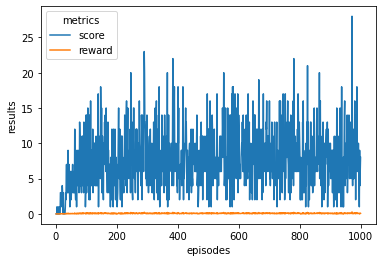

Run time: 10.04140019416809 seconds
Max. Score: 28
Mean Last Scores: 8.44


In [7]:
N0 = 1
gamma = 0.2

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))